In [1]:
from Aggregator.SimulatedAggregator import SimulatedAggregator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from random import *
import scipy as sc

from collections import defaultdict

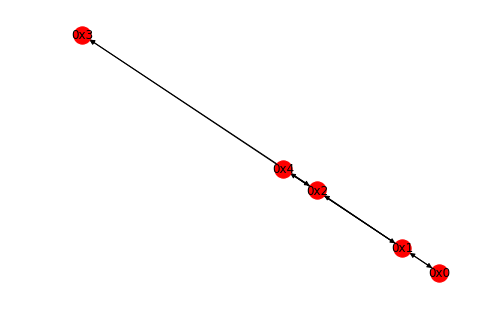

In [2]:
agg = SimulatedAggregator(10, None, 5)
nx.draw(agg.networks[0], with_labels=True)
plt.show()

In [3]:
matrix = agg.matrices[0]
goal = agg.goal_balance[0]
abs_max = np.absolute(goal).max()

In [4]:
def mutate(matrix, mutation_rate=0.1, deviations_divider=3):
    selection = sc.sparse.rand(*matrix.shape, mutation_rate) > 0 # look if always 10% then problem
    amounts = np.random.normal(0, abs_max/deviations_divider, len(selection.data))
        
    matrix[selection] += amounts
    matrix[matrix < 0] = 0
        
    return matrix

def base_individual(base_matrix):
    matrix = base_matrix.copy()
    return create_individual(matrix)
    

def create_individual(matrix):
    individual = { "matrix": matrix }
    update_individual(individual)
    
    return individual

def update_individual(individual):
    cons_violation, cost = agg.block_cost(individual["matrix"], goal)
    
    individual["cons_violation"] = cons_violation
    individual["cost"] = cost
    individual["combined_cost"] = cost + cons_violation
    individual["valid"] = cons_violation == 0
    individual["crowding_dist"] = 0.
    
correction_matrix = np.ones((5,5)) # change size
np.fill_diagonal(correction_matrix, 0.)

def correct_diagonal(matrix):
    matrix = matrix.multiply(correction_matrix).tolil()
    
    return matrix


In [5]:
def fast_non_dominant_sort(P, cost="combined_cost"):
    Sx = defaultdict(list) # dict nondominating per p 
    nx = defaultdict(int)  # dict increment dominination counter of p 
    xrank = np.zeros(len(P))
    Fi = []
    
    for pid, pv in enumerate(P):
        for qid, qv in enumerate(P):
            if pv[cost] <= qv[cost]: # if p dominates q -> less cost
                Sx[pid].append(qid)
            else:
                nx[pid] += 1
                
        if nx[pid] == 0:
            xrank[pid] = 1
            Fi.append(pid)
                        
    i = 1
    while Fi:
        Q = []
        
        for p in xrank:
            
            for qid, qv in Sx.items():
                nx[qid] -= 1
                
                if nx[qid] == 0: # q belongs to the next front
                    xrank[qid] = i + 1

                    Q.append(qid)
                    
            i += 1 
            Fi = Q
            
    return xrank          
            

In [6]:
POSITIVE_INFINITY = float("inf")

def crowding_distance(front):
    for i in front:
        i["crowding_dist"] = 0.
    
    n_solutions = len(front)
    
    x, y = front[0]["matrix"].shape
    
    for i in range(x):
        for j in range(y):
            sorted_solutions = sorted(front, key=lambda x: x["matrix"][i, j])      
            sorted_solutions, matrices = zip(*[(x, x["matrix"]) for x in sorted_solutions])

            min_value = matrices[0][i, j]
            max_value = matrices[-1][i, j]
            
            sorted_solutions[0]["crowding_dist"] += POSITIVE_INFINITY
            sorted_solutions[-1]["crowding_dist"] += POSITIVE_INFINITY
            
            for s in range(1, n_solutions-1):
                diff = matrices[s+1][i, j] - matrices[s-1][i, j]
                
                if max_value - min_value == 0:
                    sorted_solutions[s]["crowding_dist"] += 0
                else:
                    sorted_solutions[s]["crowding_dist"] += diff / (max_value - min_value)

In [7]:
def binary_crossover(parent1, parent2, cost="combined_cost"):
    if parent1["matrix"].shape != parent2["matrix"].shape:
        raise Exception("Parents should have same shape")
    
    total = parent1[cost] + parent2[cost]
    P1 = parent1[cost] / total

    selection = np.random.rand(*parent1["matrix"].shape) > P1

    child = parent2["matrix"].copy()
    child[selection] = parent1["matrix"][selection]
    
    return create_individual(child)

In [ ]:
def SBX_crossover():
    pass

In [8]:
def tournament_selector(P, cost="combined_cost", tournament_size=2):
    winner = choice(P)
    
    for _ in range(tournament_size-1):
        candidate = choice(P)
        
        if candidate[cost] > winner[cost]:
            winner = candidate
    
    return winner

In [9]:
def create_children(P, n_children, crossover_method=binary_crossover, cost="combined_cost"):
    parents_set = [(tournament_selector(P, cost), tournament_selector(P, cost)) 
                   for _ in range(n_children)]
    
    return [crossover_method(*parents, cost=cost) for parents in parents_set]

In [10]:
def NSGAII_step(P, parent_percentage=0.8, cost="combined_cost"):
    n = int(len(P) * parent_percentage)
    
    F = fast_non_dominant_sort(P, cost)
    fronts = sorted(list(set(F)))
    parents = []
    
    i = 0
    f = 1
        
    while len(parents) + len(F[F==f]) < n:
        crowding_distance(P[F==f])
        parents.extend(P[F==f])
        i += 1
        f = fronts[i]
        
    s = sorted(P[F==f], key=lambda x: x["crowding_dist"], reverse=True)
        
    parents.extend(s[:int(n - len(parents))])
       
    children = create_children(parents, int(100 - n), cost=cost)
    
    for child in children:
        child["matrix"] = mutate(child["matrix"])
        update_individual(child)
    
    return np.array(parents + children)

In [18]:
P = np.array([base_individual(matrix) for i in range(1000)])

for individual in P:
    individual["matrix"] = mutate(individual["matrix"])
    update_individual(individual)

In [19]:
log_data = []

In [20]:
for i in range(1000):
    P = NSGAII_step(P, cost="combined_cost")
    
    log_data.append(np.array([(x["cost"], x["cons_violation"], x["combined_cost"]) for x in P]).mean(axis=0))

ZeroDivisionError: division by zero

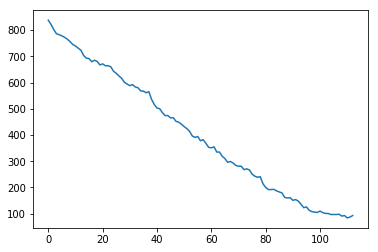

In [22]:
plt.plot(np.array(log_data)[:,0])

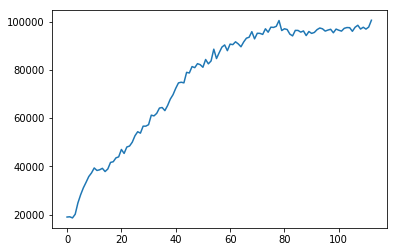

In [23]:
plt.plot(np.array(log_data)[:,1])

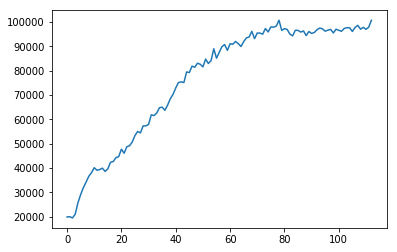

In [24]:
plt.plot(np.array(log_data)[:,2])